# Algae Monitoring Buoy Demonstration Notebook

### This notebook demonstrates how data can be visualized from an algae monitoring IoT buoy. Instructions for how to build one of these buoys can be found [here](https://github.com/oyetkin/iotbuoy).

You need to !pip install yagmail  in order to enable automated email triggering

### Display an image of the buoy in its current state for reference.

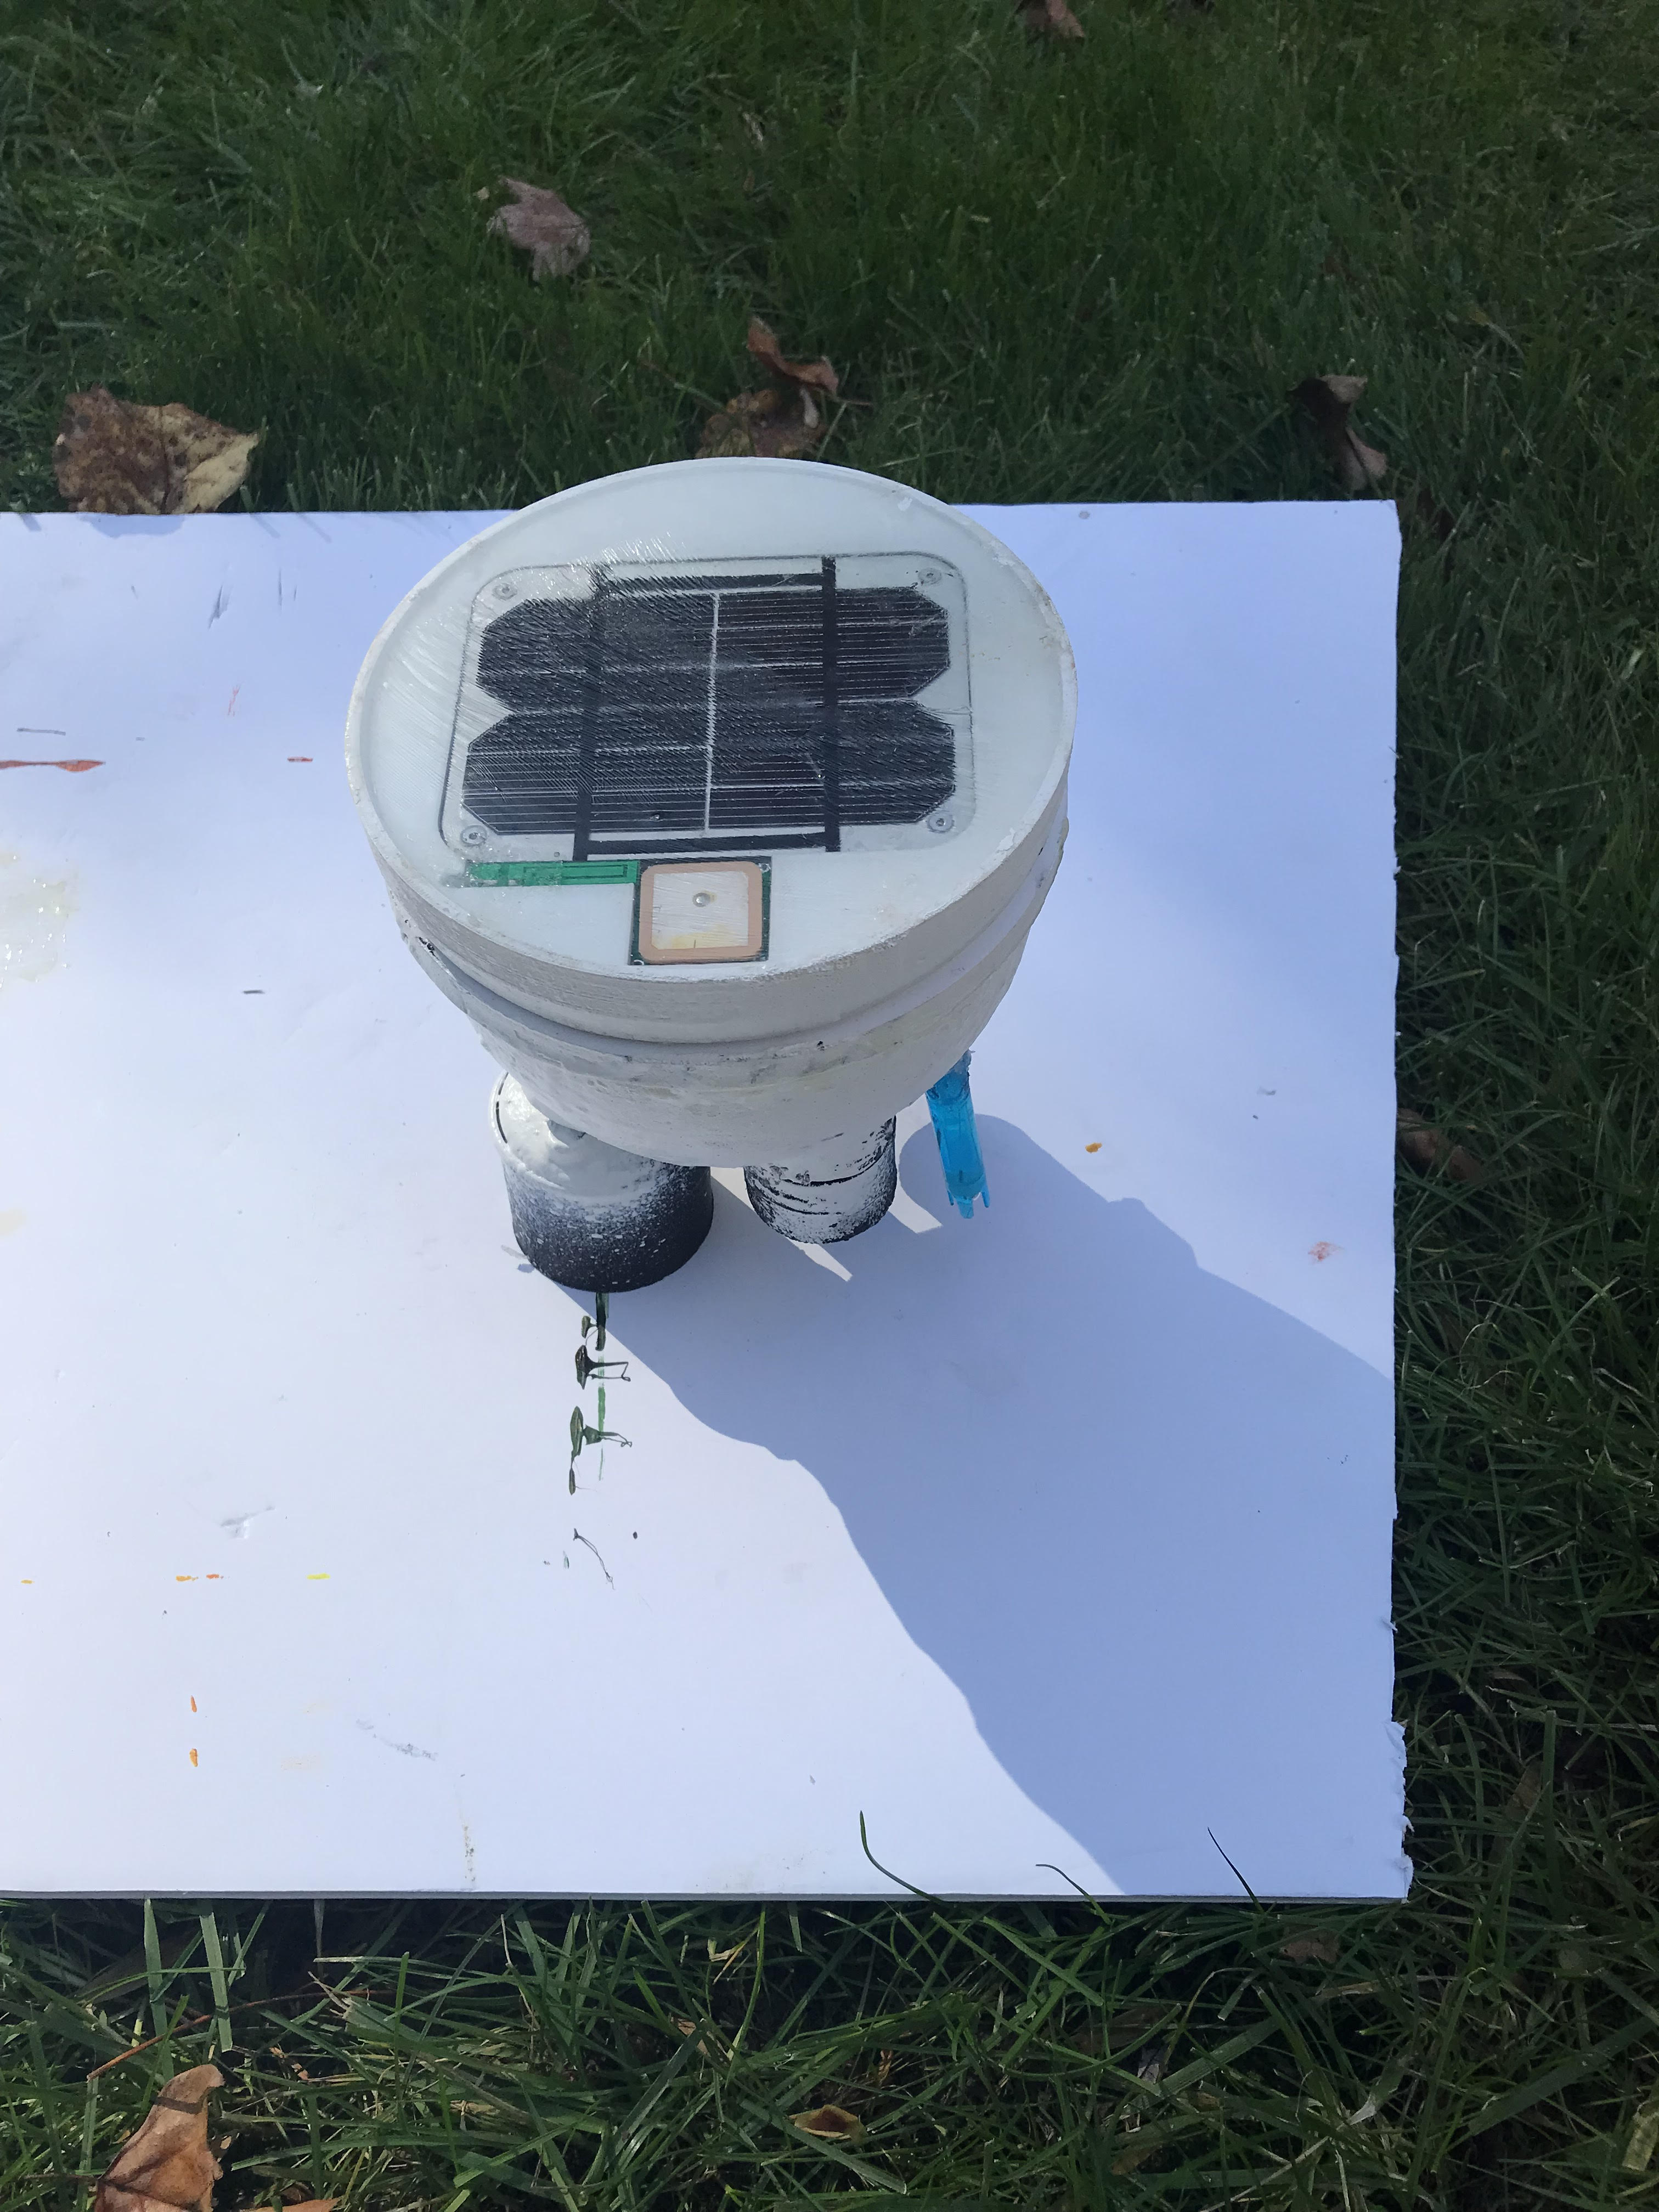

In [1]:
from IPython.core.display import Image, display
display(Image('BackyardBuoy.jpg', width=400))

### Import necessary libraries

In [2]:
%matplotlib inline
import urllib.request, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button
import matplotlib as mpl
import numpy as np
import datetime as dt
from IPython.display import clear_output
import time
import yagmail

### Create a function to query measurements

In [3]:
def get_data(measurement):
    
#     Download all JSON data from the specified server using the python requests library
    with urllib.request.urlopen("http://52.26.55.255:8080/api/v0p1/sensor_by_id/Ursula_2") as url:
        data = json.loads(url.read().decode())
        
    # Create a pandas dataframe 
    df = pd.DataFrame.from_records(data)
    
    # Create two lists, one with measurement voltage data and one with associated timestamps
    measurementdata = df[df['measurement_name'] == measurement]
    measurementtimes = (measurementdata['receipt_time']).tolist()
    newtime = []
    for timeinfo in measurementtimes:
        newtime.append(dt.datetime.fromtimestamp(timeinfo))
    measurementvals = measurementdata['value'].tolist()
    measurementunit = measurementdata['unit'].tolist()
    
    return newtime, measurementvals, measurementunit

### Create a function to save data as a CSV file

In [4]:
def to_CSV(measurement):
    
    # Download all JSON data from the specified server using the python requests library
    with urllib.request.urlopen("http://52.26.55.255:8080/api/v0p1/sensor_by_id/Ursula_2") as url:
        data = json.loads(url.read().decode())
        
    # Create a pandas dataframe 
    df = pd.DataFrame.from_records(data)
    file_name = measurement + str(dt.datetime.now().date()) + ".csv"
    df.to_csv(file_name)

### Save pressure data to a CSV file

In [5]:
to_CSV("pressure")

### Define a live plotting function that accepts a measurement request array

In [6]:
def live_plot(measurement_request, figsize=(30,10), ylimit=None):

    clear_output(wait=True)
    title_string = ""
    if isinstance(measurement_request, str):
        plt.figure(figsize=figsize)
        ax = plt.subplot()
        plt.plot_date(get_data(measurement_request)[0], get_data(measurement_request)[1], label=measurement_request,linestyle='dashed')
        title_string += measurement_request + ", "
        plt.title("Change in " + title_string + "over time", fontsize=30)
        plt.grid(True)
        plt.legend(loc='center left') # the plot evolves to the right
        plt.legend(loc="upper left", fontsize=20)
        plt.xlabel('Date & Time', fontsize=20)
        plt.ylabel('Measurement', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        if ylimit != None:
            plt.ylim(ylimit[0], ylimit[1])
        # Set the maximum graph x-axis extent to tomorrow
        year = (dt.datetime.now()).year
        month = (dt.datetime.now()).month
        day = (dt.datetime.now()).day
        hour = (dt.datetime.now()).hour

        plt.axis([dt.date(2021, 12, 25), dt.date(year, month, day+1), 0, None])
        plt.show();
        print(measurement_request + " value " + str(get_data(measurement_request)[1][-1]) 
              + " " + str(get_data(measurement_request)[2][-1]) + ",     Recorded at " + str(get_data(measurement_request)[0][-1]) + " UTC")
        timetest = dt.datetime.now()-get_data(measurement_request)[0][-1]
        print("How long ago? (HH:MM:SS.000): " + str(timetest) + "\n\n")
    else:
        for measurement in measurement_request:
            plt.figure(figsize=figsize)
            plt.plot_date(get_data(measurement)[0], get_data(measurement)[1], label=measurement,linestyle='dashed')
            title_string = measurement
            plt.title("Change in " + title_string + " over time", fontsize=30)
            plt.grid(True)
            plt.legend(loc='center left') # the plot evolves to the right
            plt.legend(loc="upper left", fontsize=20)
            plt.xlabel('Date & Time', fontsize=20)
            plt.ylabel('Measurement', fontsize=20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            if ylimit != None:
                plt.ylim(ylimit[0], ylimit[1])
            # Set the maximum graph x-axis extent to tomorrow
            year = (dt.datetime.now()).year
            month = (dt.datetime.now()).month
            day = (dt.datetime.now()).day
            hour = (dt.datetime.now()).hour

            plt.axis([dt.date(2021, 12, 25), dt.date(year, month, day+1), 0, None])
            plt.show();
            print(measurement + " value " + str(get_data(measurement)[1][-1]) 
              + " " + str(get_data(measurement)[2][-1]) + ",     Recorded at " + str(get_data(measurement)[0][-1]) + " UTC")       
            timetest = dt.datetime.now()-get_data(measurement)[0][-1]
            print("How long ago? (HH:MM:SS.000): " + str(timetest) + "\n\n")

### Define triggering function
This function uses a gmail account called iot.trigger@gmail.com.
The password for this email is 'secretpassword'.

In [7]:
def check_triggered(measurement_list, recipient):
    
    # Check each measurement requested by the user for min/max values
    for measurement in measurement_list:
        
        # Check to see if measurement value above maximum
        if get_data(measurement)[1][-1] > measurement_list[measurement]["max"]:
            
            # Create email body
            text_string = measurement + ' above maximumum value: ' + str(get_data(measurement)[1][-1]) + " " + \
            str(get_data(measurement)[2][-1]) + '\n Recorded at ' + str(get_data(measurement)[0][-1]) + " UTC"
            
            # Send the email
            yagmail.SMTP('iot.trigger', 'secretpassword').send(recipient, measurement + ' value above limit', text_string)
        
        # Check to see if measurement value below minimum
        if get_data(measurement)[1][-1] < measurement_list[measurement]["min"]:
            
            # Create email body
            text_string = measurement + ' below minimum value: ' + str(get_data(measurement)[1][-1]) + " " + \
            str(get_data(measurement)[2][-1]) + '\n Recorded at ' + str(get_data(measurement)[0][-1]) + " UTC"
            
            # Send the email
            yagmail.SMTP('iot.trigger', 'secretpassword').send(recipient, measurement + ' value below limit', text_string)

### Demonstrate functionality of triggering function
Change to your email for demonstration

In [8]:
# Define measurements to monitor and set minimum and maximum values for each
trigger_request = {'fluorescence': {'min':0,'max': 8.5}, 'voltage': {'min': 3.2,'max': 4.2}}

# Call trigger query function
check_triggered(trigger_request, 'alexander.horvath@ama-inc.com')

### Continuously call live plotting function at specified intervals

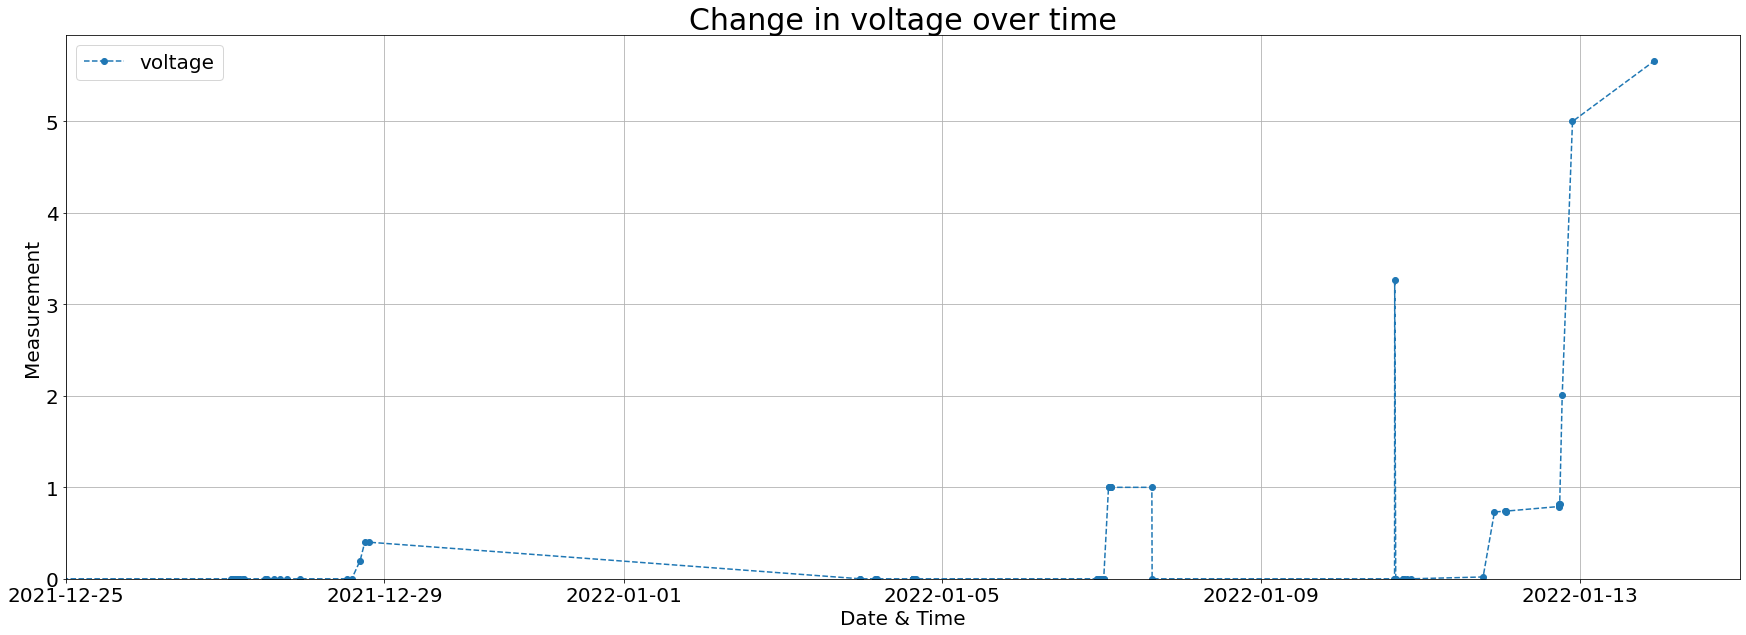

voltage value 5.66 Volts,     Recorded at 2022-01-13 22:16:38.927946 UTC
How long ago? (HH:MM:SS.000): 2:48:05.055492




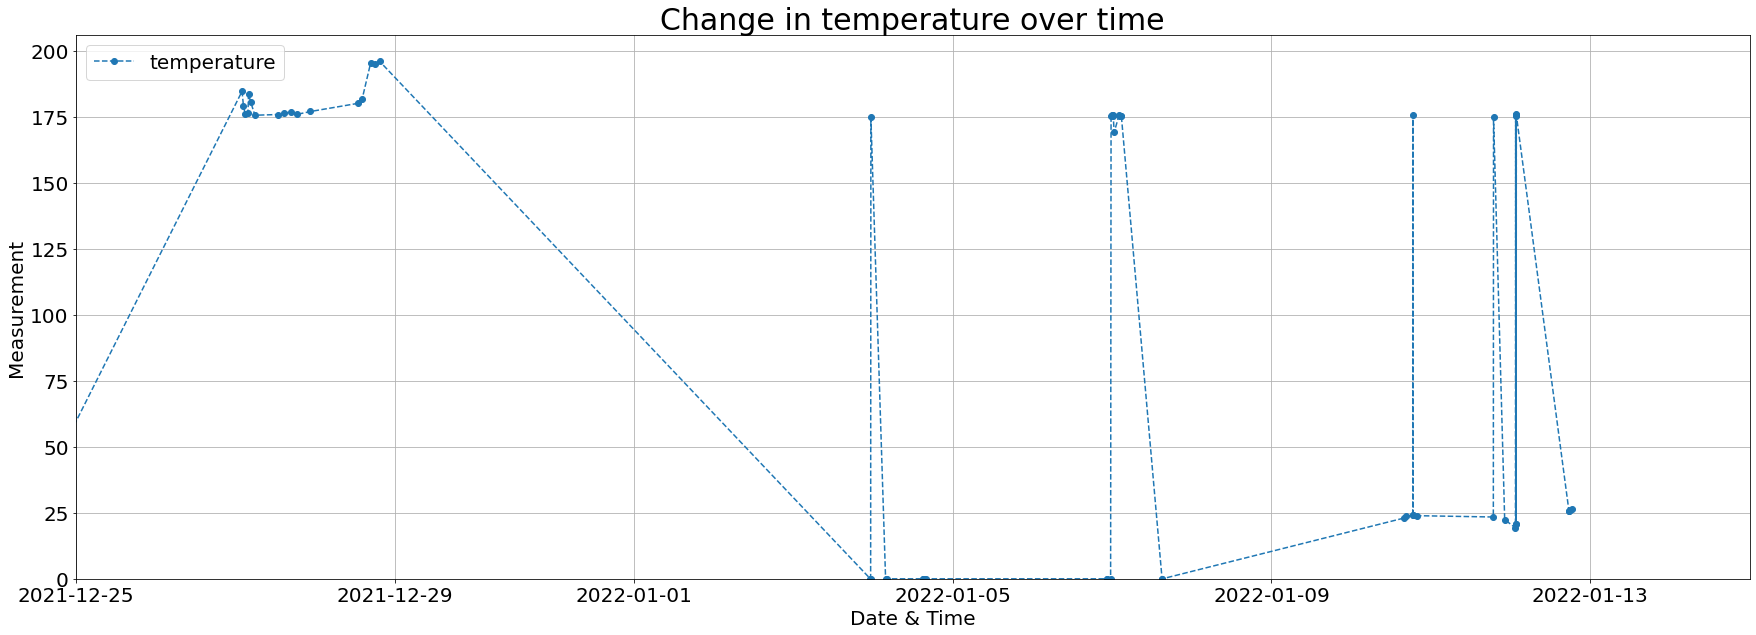

temperature value 26.4 Celsius,     Recorded at 2022-01-12 18:38:06.697230 UTC
How long ago? (HH:MM:SS.000): 1 day, 6:26:54.086812




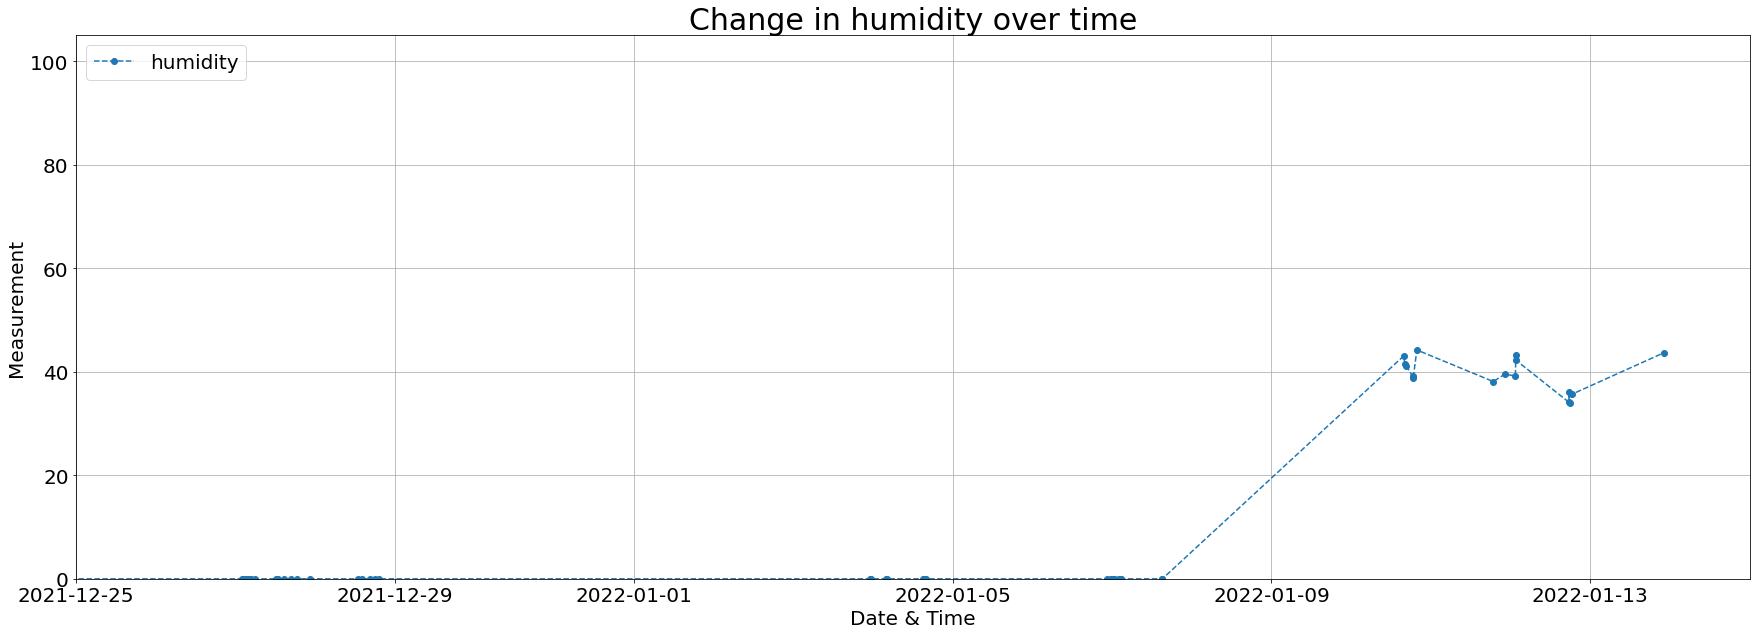

humidity value 43.7 Relative %,     Recorded at 2022-01-13 22:17:00.001371 UTC
How long ago? (HH:MM:SS.000): 2:48:17.612213




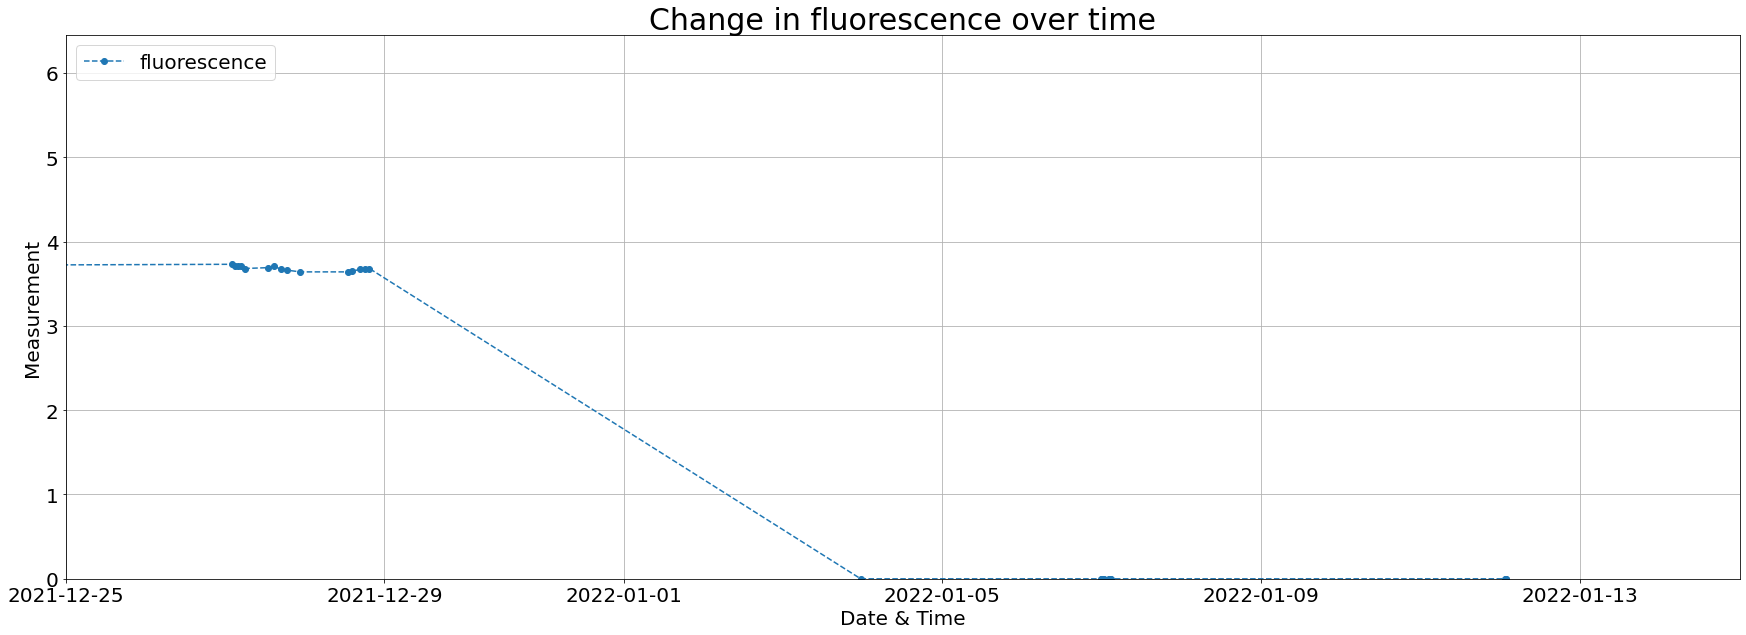

fluorescence value 0.0 Relative %,     Recorded at 2022-01-12 01:44:41.244370 UTC
How long ago? (HH:MM:SS.000): 1 day, 23:20:53.127536




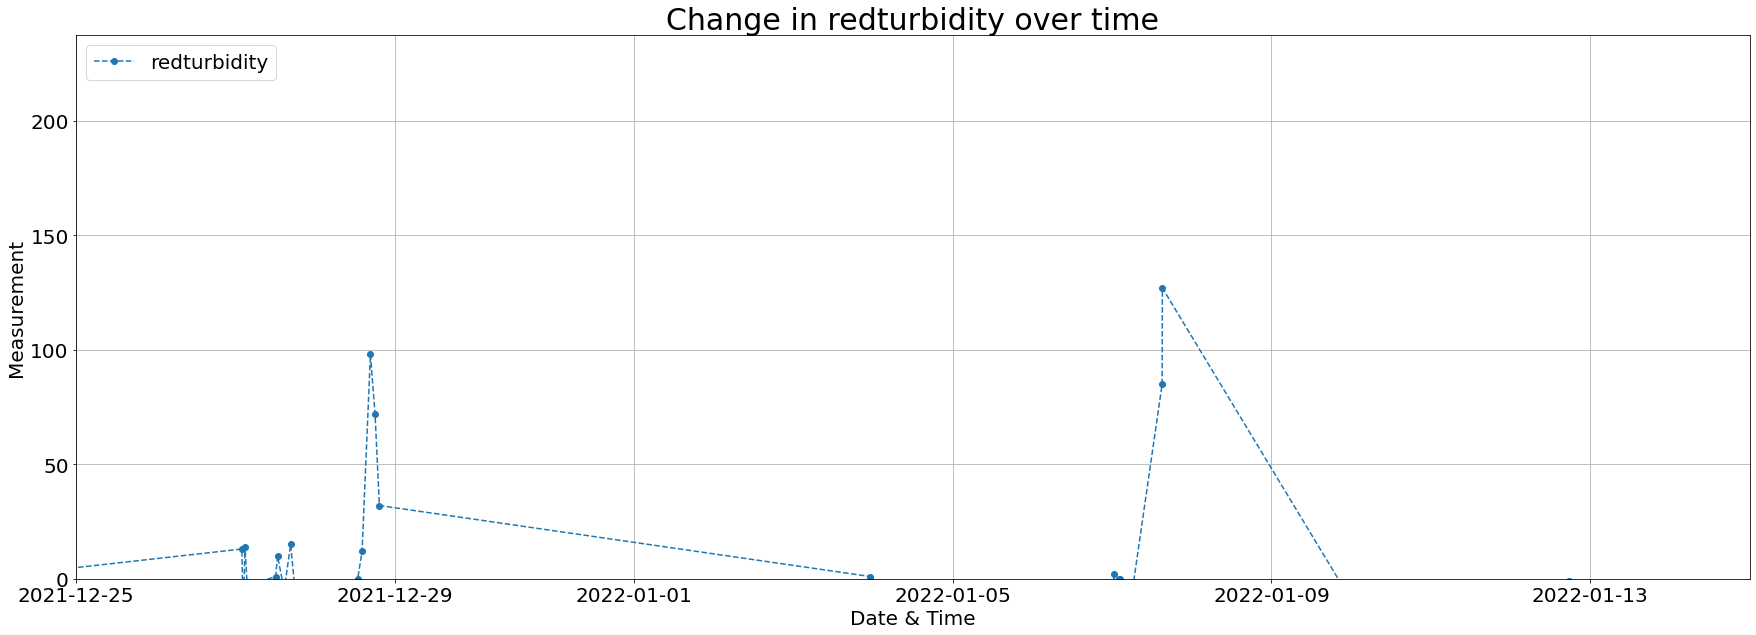

redturbidity value -44.0 Relative %,     Recorded at 2022-01-12 18:38:35.902746 UTC
How long ago? (HH:MM:SS.000): 1 day, 6:27:15.186401




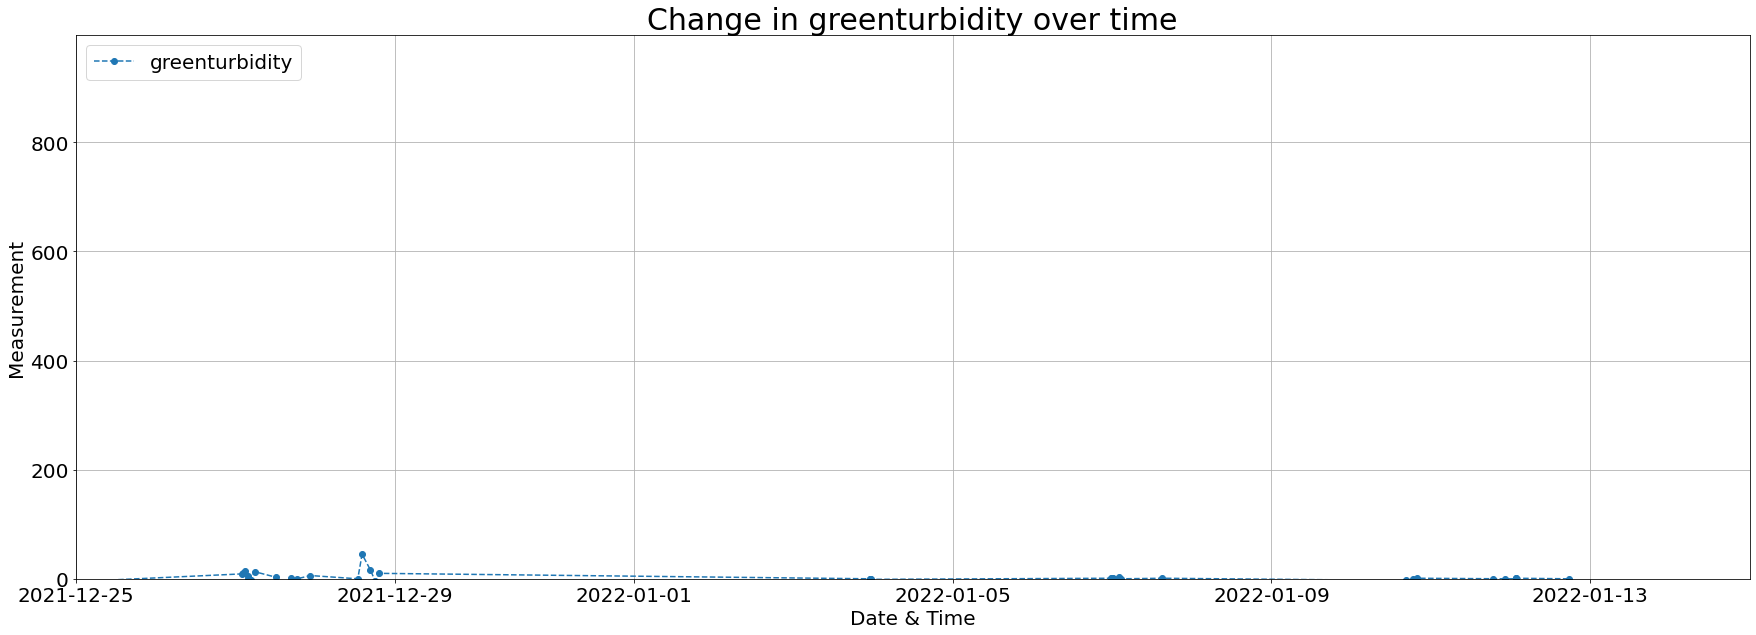

greenturbidity value 0.0 Relative %,     Recorded at 2022-01-12 17:39:30.928455 UTC
How long ago? (HH:MM:SS.000): 1 day, 7:26:37.036458




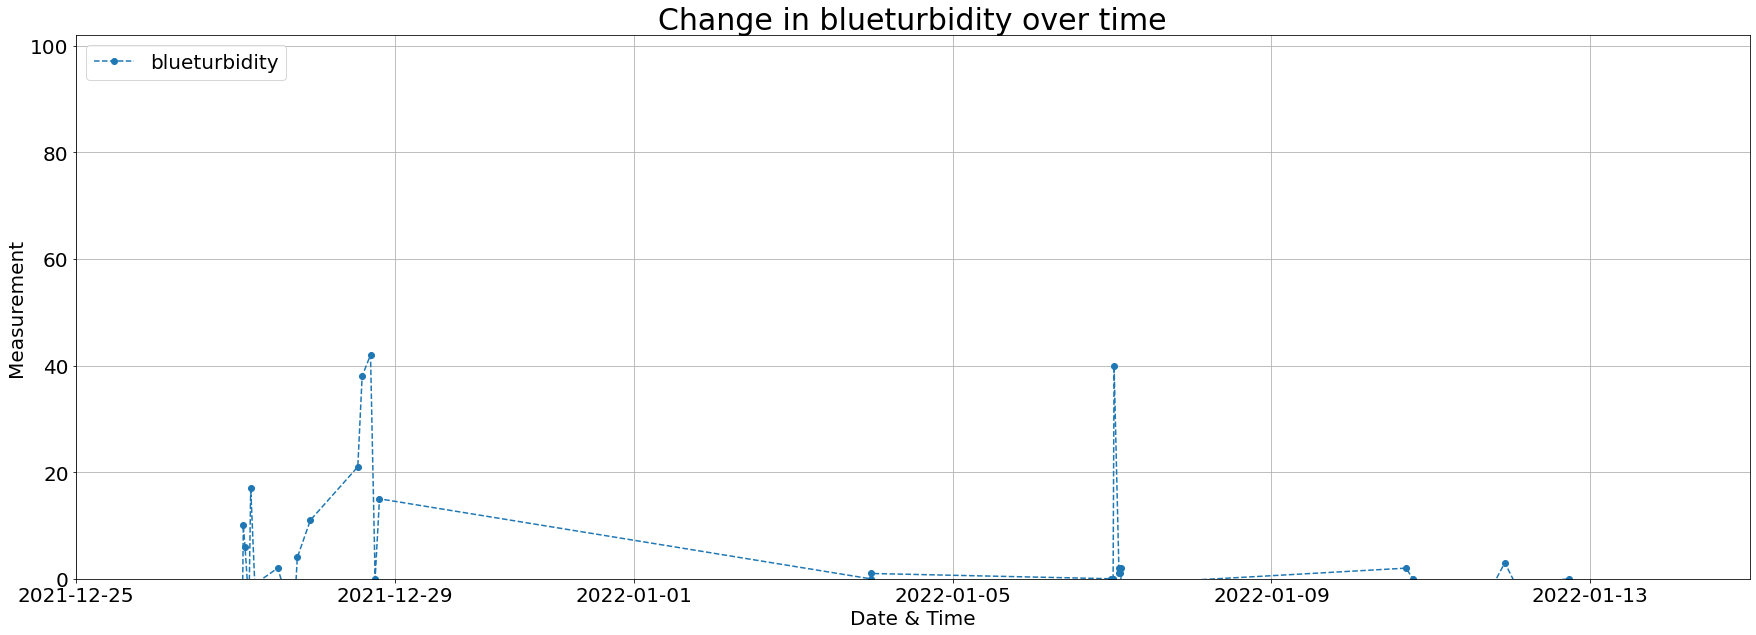

blueturbidity value 0.0 Relative %,     Recorded at 2022-01-12 17:40:14.533388 UTC


In [ ]:
while True:
    # Enter the measurements to display on the graph. 
    measurement_request = ['voltage','temperature', 'humidity', 'fluorescence', 'redturbidity', 'greenturbidity', 'blueturbidity']

    live_plot(measurement_request)
    
#     trigger_request = {'fluorescence': {'min':0,'max': 8.5}, 'voltage': {'min': 3.2,'max': 4.2}}
#     check_triggered(trigger_request)